In [269]:
# trying to code up the following model
# x -> [x^0, x^1, x^2]*\vec{w} -> yhat
# i.e. the first layers will create polynomial features
# and then connecting them linearly to the output
# makes a linear polynomial model

In [270]:
import jax.numpy as jnp
import jax
import optax

import numpy as np

import matplotlib.pyplot as plt

In [271]:
from time import sleep

In [272]:
from functools import partial

In [273]:
from tqdm.notebook import trange, tqdm

In [274]:
from typing import Dict

In [275]:
seed_fn = lambda : np.random.randint(0, 1e6)

In [276]:
seed_fn()

879373

In [277]:
units_poly = 10
units = 4
# units = 200
output_units = 1
initial_params = {
    'w1':jax.random.normal(shape=[units_poly, units], key=jax.random.PRNGKey(seed_fn())),
    'w2':jax.random.normal(shape=[units, output_units], key=jax.random.PRNGKey(seed_fn())),
}

In [278]:
def ann(x: jnp.ndarray, params: Dict) -> jnp.ndarray:
    x = jnp.column_stack([jnp.power(x, i) for i in range(units_poly)])
    x = jnp.dot(x, params['w1'])
    x = jax.nn.sigmoid(x)
    x = jnp.dot(x, params['w2'])
    return x

In [279]:
x = np.arange(0, 1, 0.01)[:,np.newaxis]
# x_fine = np.arange(-0.1, 1.1, 0.001)[:,np.newaxis]
x_fine = np.arange(0, 1., 0.001)[:,np.newaxis]

In [280]:
ann(x, initial_params).shape

(100, 1)

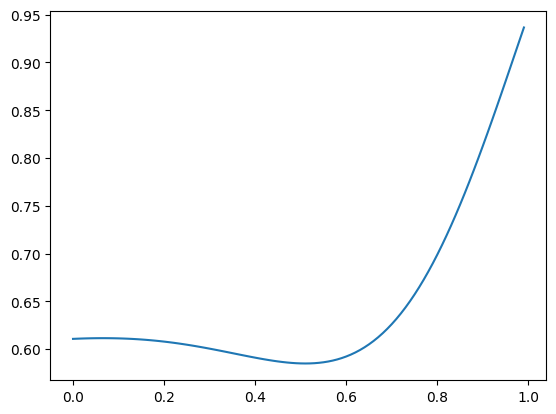

In [281]:
plt.plot(x, ann(x, initial_params))

In [282]:
def gen_data():
    n_samples = 100
    x = np.random.uniform(0, 1, n_samples)[:,np.newaxis]
    # y = x * np.sin(x/0.3)
    y = x * np.sin(x/0.1)
    
    # y[0] = 2
    
    return x, y

In [283]:
X, y = gen_data()

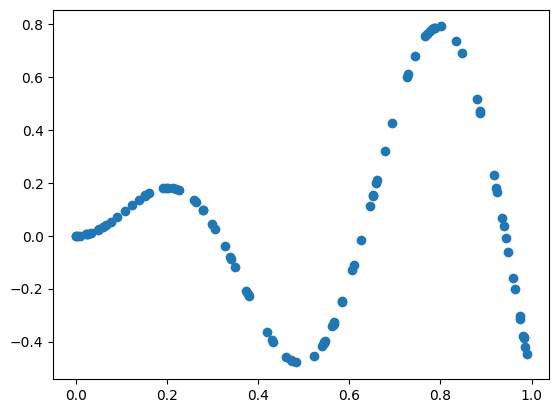

In [284]:
plt.plot(X, y, 'o')
# plt.plot(X, ann(X, initial_params), 'o')

In [285]:
# @partial(jax.jit, static_argnames=['model'])

# note here that we use the global model variable `ann`

def loss_fn(params, X, y):
    yhat = ann(X, params)
    loss_value = (y - yhat)**2
    return loss_value.mean()

In [286]:
loss_fn(initial_params, X, y)

Array(0.5222349, dtype=float32)

In [287]:
def fit(params, optimizer):
    epochs = 100000
    every = epochs//100
    losses = []
    opt_state = optimizer.init(params)
    model = ann
    
    @jax.jit
    # @partial(jax.jit, static_argnames=['model'])
    # @partial(jax.jit, static_argnums=(0,))
    def step(params, opt_state, X, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, X, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    
    # https://stackoverflow.com/questions/37506645/can-i-add-message-to-the-tqdm-progressbar
    loop_obj = tqdm(np.arange(epochs))

    # for i in trange(100):
    for i in loop_obj:
        params, opt_state, loss_value = step(params, opt_state, X, y)
        losses.append(loss_value)
        if i % every == 0:
            loop_obj.set_description(f"Epoch: {i}")  # Adds text before progessbar
            loop_obj.set_postfix_str(f"Loss: {loss_value:,.3e}")  # Adds text after progressbar
        
    return params, np.array(losses)

In [288]:
initial_params

{'w1': Array([[-0.49537104, -1.8473058 ,  0.26209357,  1.7127407 ],
        [ 0.01208647,  1.3706298 ,  0.84154063, -1.3824116 ],
        [ 0.9601388 ,  0.84623426,  0.18357614,  0.12696101],
        [-1.2832412 ,  0.34939346, -0.8593654 ,  0.29941198],
        [-0.1528516 , -1.079924  , -0.11473612, -1.0664951 ],
        [ 1.3217074 , -0.32106346,  2.0122626 ,  2.3345587 ],
        [ 0.06356669, -0.6469306 ,  1.878951  ,  1.858071  ],
        [ 0.87820315,  0.12754571,  0.24466676, -1.3420662 ],
        [-1.3513262 , -1.4913713 , -1.762778  , -0.01201998],
        [-0.7973886 ,  0.9769658 , -0.338471  ,  0.6746467 ]],      dtype=float32),
 'w2': Array([[-0.22658312],
        [-0.5459068 ],
        [ 0.8373134 ],
        [ 0.351269  ]], dtype=float32)}

In [289]:
ann

<function __main__.ann(x: jax.Array, params: Dict) -> jax.Array>

In [290]:
optimizer = optax.adam(learning_rate=1e-3)
params, losses = fit(initial_params, optimizer)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [291]:
params

{'w1': Array([[  3.1787605 ,  -2.9435542 ,  -2.2663286 ,   1.6748226 ],
        [ -3.1484935 ,   6.313606  ,   4.067827  ,  -1.1447407 ],
        [  0.13248773,   4.524483  ,  -0.162079  ,  26.47657   ],
        [ -2.7286146 ,   1.2913123 ,  -2.4387217 ,  -4.66086   ],
        [ -3.2890599 ,  -4.2184424 ,  -0.5685248 , -11.765837  ],
        [ -1.8972554 ,  -4.70322   ,   2.1593862 ,  -2.0772734 ],
        [ -1.8274173 ,  -3.1449118 ,   1.4047673 ,   1.8472013 ],
        [  1.427003  ,   0.2978529 ,  -1.1017215 ,  -1.9622452 ],
        [  1.0698268 ,   0.7606194 ,  -3.1281796 ,  -2.4785123 ],
        [  1.9889032 ,   4.4955106 ,  -0.89990157,  -2.3052435 ]],      dtype=float32),
 'w2': Array([[-2.7336245],
        [-3.811675 ],
        [ 4.033943 ],
        [ 2.8900635]], dtype=float32)}

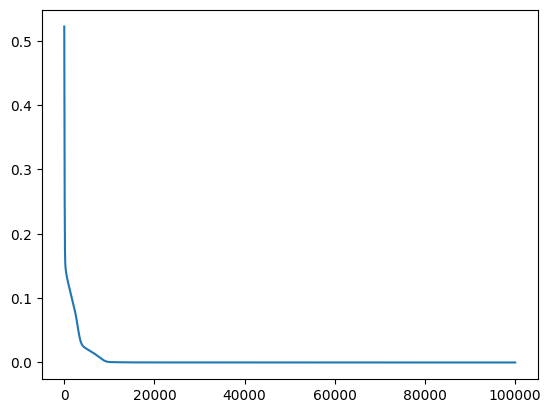

In [292]:
plt.plot(losses)

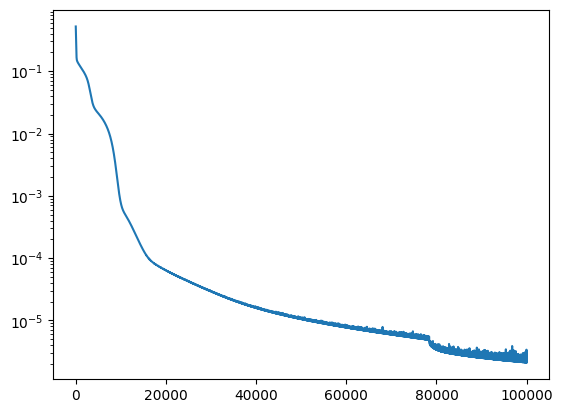

In [293]:
plt.plot(losses)
plt.yscale('log')

In [294]:
yhat = ann(X, params)

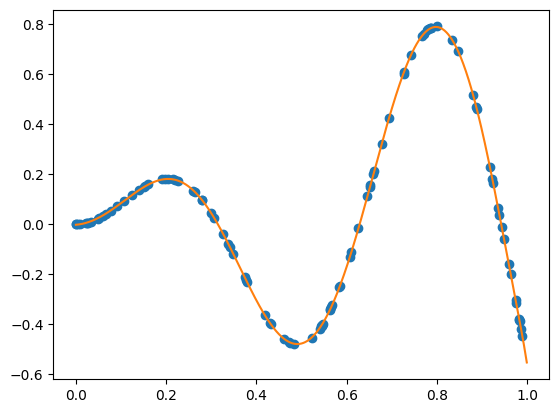

In [295]:
plt.plot(X, y, 'o')
# plt.plot(X, ann(X, initial_params), 'o')
plt.plot(x_fine, ann(x_fine, params), '-')